In [ ]:
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

## Public Utilities Data - Shmueli Chapter 15.1

Table 15.1 gives corporate data on 22 public utilities in the United States (the variable definitions are given in the table footnote). *We are interested in forming groups of similar utilities.*

[Click here for the data.](https://drive.google.com/uc?download&id=1KLTyzD0q9c76jEPRPe9epXPc0Oi3Uo74)

 The records to be clustered are the utilities, and the clustering will be based on the eight measurements on each utility. An example where clustering would be useful is a study to predict the cost impact of deregulation. To do the requisite analysis, economists would need to build a detailed cost model of the various utilities. It would save a considerable amount of time and effort if we could cluster similar types of utilities and build detailed cost models for just one "typical" utility in each cluster and then scale up from these models to estimate results for all utilities.


 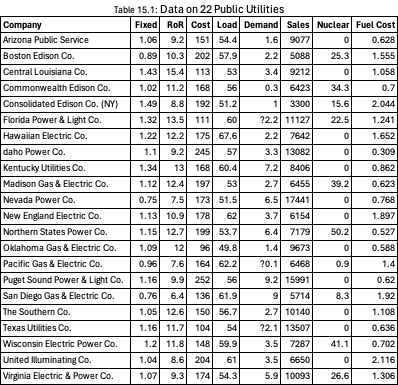

Fixed = fixed-charge covering ratio (income/debt); RoR = rate of return on capital

Cost = cost per kilowatt capacity in place; Load = annual load factor

Demand = peak kilowatthour demand growth from 1974 to 1975

Sales = sales (kilowatthour use per year)

Nuclear = percent nuclear

Fuel Cost = total fuel costs (cents per kilowatthour)

In [ ]:
from google.colab import files
uploaded = files.upload()



In [ ]:
utilities_df = pd.read_csv('Utilities.csv')
# set row names to the utilities column
utilities_df.set_index('Company', inplace=True)
# while not required, the conversion of integer data to float
# will avoid a warning when applying the scale function
utilities_df = utilities_df.apply(lambda x: x.astype('float64'))


In order for similarities to treat each feature "equally" we need to normalize the data.  

Here we create normalized z-scores for each value by subtracting the mean and dividing by SD.

Then we calculate the distances between each utility.

In [ ]:
#need to normalize:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(utilities_df)
scaled_data = scaler.transform(utilities_df)

# create a data frame
utilities_df_norm = pd.DataFrame(scaled_data, columns=utilities_df.columns, index=utilities_df.index)



In [ ]:
# now find the pairwise distances

d_norm = pairwise.pairwise_distances(utilities_df_norm, metric='euclidean')
util_distmat = pd.DataFrame(d_norm, columns=utilities_df.index, index=utilities_df.index)#
util_distmat.round(2)

Lets find the most similar Utilities to a specific one - let's say Texas

In [ ]:
util='Texas'
distances_util = util_distmat.loc[util].drop(util) # want minimum distance, not including itself!

# Find the indices of the smallest distances - these are the most similar entities to C
# You might want to retrieve the top N similar; for example, top 3

top_similar_indices = distances_util.nsmallest(3).index.tolist()
top_similar_indices

['Oklahoma', 'Arizona ', 'Southern']

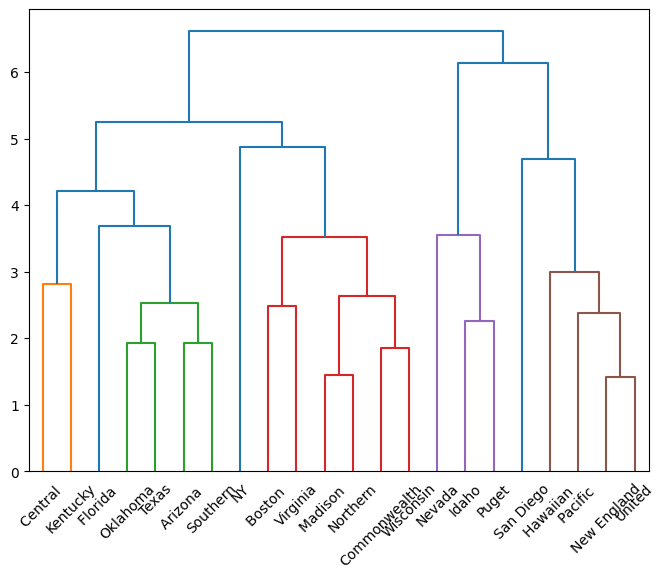

In [ ]:
# code for hierarchical clustering
plt.figure(figsize=(8, 6))
# in linkage() set argument method = 'average', 'complete', 'average', 'weighted', centroid', 'median', 'ward'
Z = linkage(utilities_df_norm, method='complete')
ddd = dendrogram(Z, labels=utilities_df_norm.index, color_threshold=3.6)


## try different linkages!!

## Creating clusters by Cutting the Dendrogram

In [ ]:
memb = fcluster(linkage(utilities_df_norm, method='complete'), 7, criterion='maxclust')
memb = pd.Series(memb, index=utilities_df_norm.index)
for key, item in memb.groupby(memb):
     print(key, ': ', ', '.join(item.index))


1 :  Central , Kentucky
2 :  Arizona , Florida , Oklahoma, Southern, Texas
3 :  Boston , Commonwealth, Madison , Northern, Wisconsin, Virginia
4 :  NY
5 :  Idaho, Nevada, Puget
6 :  Hawaiian , New England, Pacific , United
7 :  San Diego


## Cluster heatmap

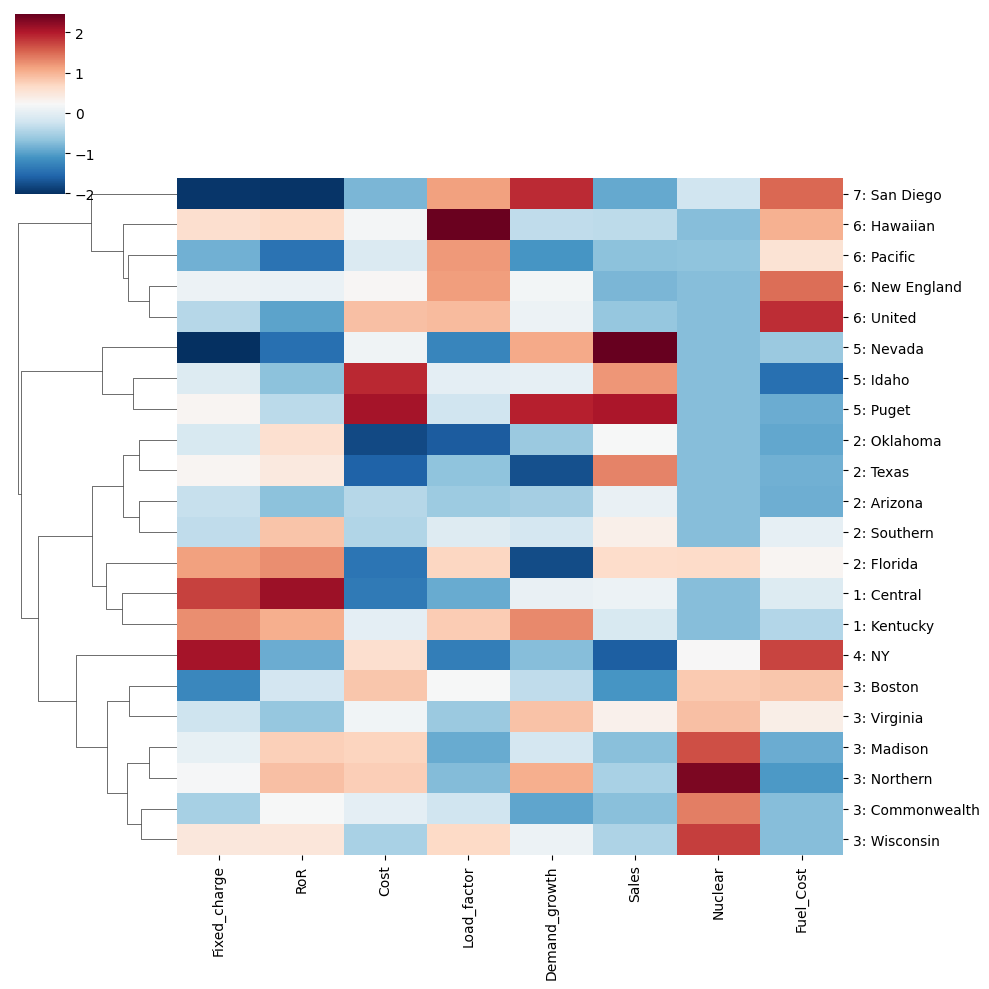

In [ ]:
# set labels as cluster membership and utility name
utilities_df_norm.index = ['{}: {}'.format(cluster, state)
                           for cluster, state in zip(memb, utilities_df_norm.index)]
# plot heatmap
# the '_r' suffix reverses the color mapping to large = dark
sns.clustermap(utilities_df_norm, method='ward', col_cluster=False, cmap='RdBu_r')
